<a href="https://colab.research.google.com/github/songqsh/foo1/blob/master/src/value_iter_hjb_upwind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time
start_time = time.time()

import matplotlib.pyplot as plt

__Goal__

It demonstrates that upwind FDM does not work for HJB equation. We used the same 
Whittle's flypaper ([here](https://github.com/songqsh/foo1/blob/master/src/value_iter_dirichlet_1d.ipynb)), but the transition probability is given from upwind scheme.

In [0]:
#configure
C1 = 1
C2 = 1

U_LIM = 1 #upper limit for state
L_LIM = 0 #lower limit for state

TOL = 0.001 #tolerance for iteration
MAX_ITER = 1000 #maximum iteration

In [0]:
#start MDP approximation
#configure

NUM = 10 #num of meshes in one unit state space

In [0]:
#configure

lambda_ = 0. #discount rate
sigma = 1. #diffusion coefficient
drift = lambda x,a: a #drift coefficient

run_cost = lambda x, a: (a**2+1)/2.
term_cost = lambda x: - np.log(C1*np.exp(x) + C2*np.exp(-x))

In [0]:
h = 1./NUM #mesh size in state space

s_space = np.arange(L_LIM, U_LIM+h, h) #state space

a_space = np.arange(2*L_LIM, 2*U_LIM + h, h) #action space

del_ind_space = np.array([-1,1]) #space of delta (1-step) index: -1 means left, 1 means right move

term_ind_space = np.array([0, s_space.size-1]) #space of terminal state indice

In [0]:
#transition probability by upwind
#output is probability (np array) on del_ind_space

def transition_probability(x, a):
  tp = np.zeros(del_ind_space.shape)
  
  b_ = drift(x,a)
  b_plus = np.max([b_,0])
  b_minus = np.max([-b_,0])
  
  tp[0] = (b_minus*h + sigma**2/2)/(2*sigma**2 + h*np.abs(b_)) #prob del_ind = -1
  tp[1] = (b_plus*h + sigma**2/2)/(2*sigma**2 + h*np.abs(b_)) #prob del_ind = 1
  
  #correction on prob
  if tp[1]<0:
    tp = tp - tp[1]
    tp = tp/tp.sum()
    print('>>>>corrected')

  return tp

In [7]:
#q-table and state value initialization

s_val = np.zeros(s_space.size)
q_table = np.zeros([s_space.size, a_space.size])

'''
#adjust start
for i in range(s_space.size):
  q_table[i] = term_cost(s_space[i])*np.ones(a_space.size)
'''

print('>>>>> q_table size is %i' %(q_table.size))

>>>>> q_table size is 231


In [0]:
#q-table terminal setup
for i in term_ind_space:
  for j in range(a_space.size):
    q_table[i,j] = term_cost(s_space[i])

In [0]:
#sync q_table, s_val
def q_s_sync(ind):
  s_val[ind] = np.min(q_table[ind])
  
q_s_sync(0)
q_s_sync(s_val.size-1)

In [0]:
#value iteration

eps = 1.
iter = 0
while eps>TOL and iter < MAX_ITER:
  pre_s_val = s_val.copy()
  #import pdb; pdb.set_trace()
  for i in range(1, s_space.size -1):
    for k in range(a_space.size):
      x_ = s_space[i]
      a_ = a_space[k]
      tp_ = transition_probability(x_,a_)
      run_cost_ = run_cost(x_,a_)*h**2/sigma**2
      Lambda_ = 1 + lambda_*h**2/sigma**2
      
      q_table[i,k] = (run_cost_ + tp_[0]*s_val[i-1] + tp_[1]*s_val[i+1])/Lambda_
      
    q_s_sync(i)
    
  
  eps = np.max(np.abs(pre_s_val - s_val))
  #import pdb; pdb.set_trace()
  iter += 1
  if np.mod(iter,10) == 0:
    print('iterated ' + str(iter)+';')

In [11]:
exact_val = term_cost(s_space) #exact value for performance compare
end_time = time.time()
print('elapsed time is %f seconds' %(end_time - start_time))

elapsed time is 0.184462 seconds


>>>epsilon is 0.0004464046109076726
>>>iter number is 6
>>>max norm of error is 0.9012352417839735


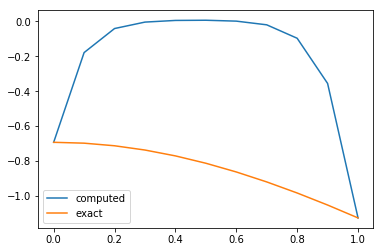

In [12]:
plt.plot(s_space, s_val, label = 'computed')
plt.plot(s_space, exact_val, label = 'exact')
plt.legend()
print('>>>epsilon is ' + str(eps))
print('>>>iter number is ' + str(iter))
print('>>>max norm of error is ' + str(np.max(np.abs(s_val-exact_val))))
